# Lab 6: MNIST with CNN Model
The purpose of this assignment is to build, train and evaluate a Convolutional Neural Network(CNN) for handwritten digit recognition using the MNIST dataset. You will also preprocess data, visualize results, and upload the work to GitHub

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import memory_profiler
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
#Check if the GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(f"Using device: {device}")

Using device: cpu


# Introduce the MNIST Dataset:

### 1. Introduction to the MNIST Dataset


The MNIST (Modified National Institute of Standards and Technology) dataset is a widely used collection of handwritten digits (0-9) which serves as a standard benchmark for testing and training image classification algorithms in machine learning.

#### Dataset Details
* Size of the dataset: MNIST contains 70000 grayscale images of handwritten digits.
   - 60000 images for training
   - 10000 images for testing
* Number of classes: 10 (digits 0 to 9)
* Image dimensions: Each image is 28x28 pixels, which represented in grayscale(values from 0 to 255)
* Format: Each image is a single channel image, it has only one color channel
  
This dataset is widely used for benchmarking machine learning models, especially Convolutional Neural Networks(CNNs)
#### Why is MNIST crucial?
* It is a simple however it is very powerful dataset for testing image classification models
* It often used for benchmarking Convolutional Neural Networks(CNNs)
* Helps in understanding image preprocessing techniques, such as normalization and transformation

In [5]:
#Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(), #Convert images to PyTorch tendor
    transforms.Normalize((0.5,),(0.5,)) #Normalize pixel values to range [-1,1]
])
#Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train= True, download = True, transform= transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train= False, download = True,transform= transform)
#Measure memory usage before loading data
memory_used_before = memory_profiler.memory_usage()[0]
#Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size =64, shuffle = True) #Training set loader
val_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False) #Validation set loader
#Measure memory usage after loading data
memory_used_after = memory_profiler.memory_usage()[0]
#Print memory usage for dataset loading
print(f"Memory consumed: {memory_used_after - memory_used_before: .2f} MB")

Memory consumed:  0.01 MB


### Preprocess the Data

#### Why the preprocessing steps were necessary?

To improve the performance of our CNN, we apply preprocessing techniques to the MNIST dataset:
- Normalization: We scale pixel values from [0,255] to [0,1] or [-1,1] to help the model train faster and improve convergence.
- ToTensor Conversion: Converts the PIL image into a PyTorch tensor, which is needed for model training.
- Other Possible Transforms: While not required, there are additional transformations which are random rotation or data augmentation could enhance generalization.

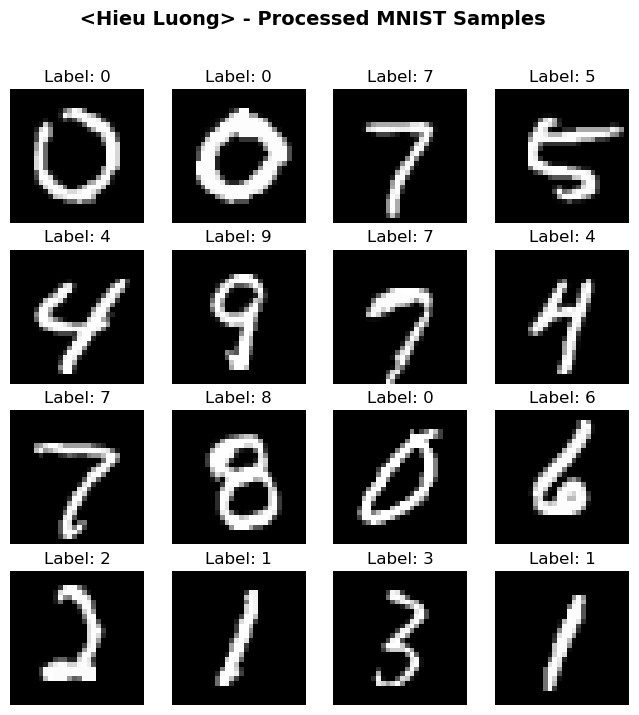

In [8]:
#Function to visualize a batch of processed images
def processed_image (dataloader, name = " Hieu Luong "):
    """
    Visualizes a batch of processes images from the given DataLoader.
    Args:
        dataloader: The DataLoader containing the images
        name: The name to be displayed in the plot title
    Functionality:
    - Extracts a batch of images and their corresponding labels
    - Displayes the first 16 images in a 4x4 grid
    - Each image is shown in grayscale with its label as the title
    """
    #Get a batch of images and labels
    images, labels = next(iter(dataloader))
    #Select the first 16 images
    images = images[:16]
    labels = labels[:16]
    #Create a figure with 4x4 grid
    fig,axes = plt.subplots(4,4, figsize=(8,8))
    fig.suptitle(f"{name} + Processed MNIST Samples", fontsize=14, fontweight="bold")
    #Iterate through images and plot them
    for i,ax in enumerate(axes.flat):
        img= images[i].squeeze().numpy() #Convert tensor to NumPy array
        ax.imshow(img, cmap="gray") #Display in grayscale
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    

    plt.show()
   

processed_image(train_loader, name=" <Hieu Luong>")

# Build a CNN Model

## Overview

The design CNN model is a deep learnig architecture which built by using PyTorch, designed for image classification on the MNIST dataset. More than that, the model contains of two convolutional layers, two pooling layers, a fully connected layer, and an output layer. The activation function has the ReLU(Rectified Linear Unit), and a softmax function is implicity applied through the loss function.

## Layer-by-Layer Breakdown

- Conv2d(16 filters): Extracts the low-level features like edges and textures
- ReLU: Introduces non-linearity for better learning
- MaxPooling: Reduces spatial dimensions from 28x28 to 14x14
- Conv2d(32 filters): Captures deeper patterns and complex structures
- ReLU activation: Further non-linearity for better learning
- MaxPooling: Reduces dimensions from 14x14 to 7x7



### Design the Model Structure

In [29]:
class CNN(torch.nn.Module):
    def __init__(self):
        """
        Initializes the CNN model with convolutional, activation, pooling and fully connected layers.
        """
        super().__init__()
        self.main = torch.nn.Sequential(
            #First Convolutional Layer
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ReLU(), # Activation function
            torch.nn.MaxPool2d(kernel_size=2, stride=2), #Reduces image size to 14x14
            #Second Convolutional Layer
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),#Activation fucntion
            torch.nn.MaxPool2d(kernel_size=2, stride=2), #Reduces image size to 7x7
            #Flatten Layer to prepare for fully connected layer
            torch.nn.Flatten(),
            #Fully connected Layer
            torch.nn.Linear(32 * 7 * 7, 128),
            torch.nn.ReLU(), #Activation function
            torch.nn.Linear(128,10) #Output Layer
        )
    def forward(self,x):
        """
        Defines the forward pass of the CNN model.
        Args:
        x: Input the tensor of the shape
        Returns:
        torch.Tensor: Output tensor of shape
        """
        out= self.main(x)
        return out

In [30]:
model = CNN()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 128]         200,832
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.79
Estimated T


### Build trainer

Implement a simple training wrapper for PyTorch network that handles the forward pass, backpropagation, and parameter updates for multiple epochs

Training Process:
- Iterate over the specified number of epochs
  
Batch Loop:

- Iterate over batches of X and y from dataloader
- Clear the gradients using optimizer.zero_grad()
- Perform a forward pass:
- Use the model to compute predictions (y_hat)
- Flatten the output to match the expected shape if necessary.
- Calculate the loss using criterion(y_hat, y)
- Perform backpropagation with loss to compute gradients
- Update model parameters using optimizer.step()
- Accumulate the loss for the batch into a running total.
  
Logging:
- At the end of each epoch, compute and print the average loss over all batches if verbose is True.

In [10]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss() # loss function - Multi class classification
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)  #Optimization algorithm - ADAM

In [11]:
def trainer(model, criterion, optimizer, train_loader, val_loader, epochs=50, device="cpu", verbose=True):
    model.to(device)
    accuracy_metric = MulticlassAccuracy(num_classes=10).to(device)  # Accuracy metric
    accuracy_list = []  # List to store the accuracy
    train_loss = []  # List to store the training loss history
    val_loss_history = []  # List to store the validation loss history
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        losses = 0  # Track total loss for training
        accuracy_metric.reset()  # Reset accuracy metric at the start of each epoch
        
        # Training loop
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Reset gradients
            y_pred = model(X)  # Forward pass
            loss = criterion(y_pred, y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            losses += loss.item()  # Track total loss
            
            # Get the predicted class and compute accuracy
            predicted = torch.argmax(y_pred, dim=1)  # Get predicted class (shape: [batch_size])
            accuracy_metric.update(predicted, y)  # Update accuracy metric
        
        # Compute average training loss and accuracy
        avg_loss = losses / len(train_loader)  # Average training loss
        avg_accuracy = accuracy_metric.compute().item()  # Average accuracy
        
        # Append values to history
        train_loss.append(avg_loss)
        accuracy_list.append(avg_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_losses = 0  # Track total validation loss
        with torch.no_grad():  # No gradient tracking during validation
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_val_pred = model(X_val)
                val_losses += criterion(y_val_pred, y_val).item()

        # Compute average validation loss
        avg_val_loss = val_losses / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print the training and validation loss/accuracy
        if verbose:
            print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
    
    return train_loss, val_loss_history, accuracy_list


In [13]:
# Train the model
loss_history,val_loss_history, accuracy_list = trainer(model, criterion, optimizer, train_loader, val_loader, epochs=50, device=device, verbose=True)


Epoch 1: Train Loss: 0.2630, Val Loss: 0.0683, Accuracy: 0.9209
Epoch 2: Train Loss: 0.0675, Val Loss: 0.0508, Accuracy: 0.9794
Epoch 3: Train Loss: 0.0497, Val Loss: 0.0355, Accuracy: 0.9848
Epoch 4: Train Loss: 0.0390, Val Loss: 0.0376, Accuracy: 0.9878
Epoch 5: Train Loss: 0.0326, Val Loss: 0.0345, Accuracy: 0.9894
Epoch 6: Train Loss: 0.0274, Val Loss: 0.0360, Accuracy: 0.9912
Epoch 7: Train Loss: 0.0230, Val Loss: 0.0299, Accuracy: 0.9927
Epoch 8: Train Loss: 0.0204, Val Loss: 0.0316, Accuracy: 0.9933
Epoch 9: Train Loss: 0.0175, Val Loss: 0.0349, Accuracy: 0.9940
Epoch 10: Train Loss: 0.0152, Val Loss: 0.0322, Accuracy: 0.9949
Epoch 11: Train Loss: 0.0124, Val Loss: 0.0382, Accuracy: 0.9958
Epoch 12: Train Loss: 0.0111, Val Loss: 0.0382, Accuracy: 0.9965
Epoch 13: Train Loss: 0.0101, Val Loss: 0.0474, Accuracy: 0.9967
Epoch 14: Train Loss: 0.0085, Val Loss: 0.0412, Accuracy: 0.9972
Epoch 15: Train Loss: 0.0085, Val Loss: 0.0403, Accuracy: 0.9971
Epoch 16: Train Loss: 0.0064, Val 

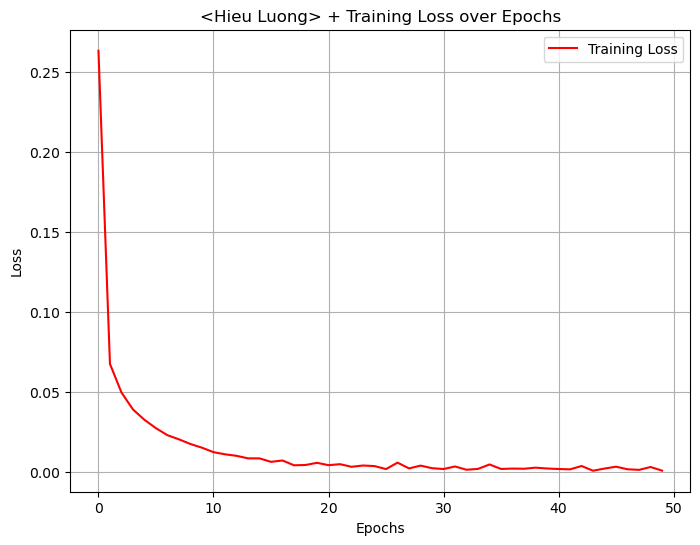

In [16]:
def plot_training_loss(train_loss):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color = "red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("<Hieu Luong> + Training Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_training_loss(loss_history)

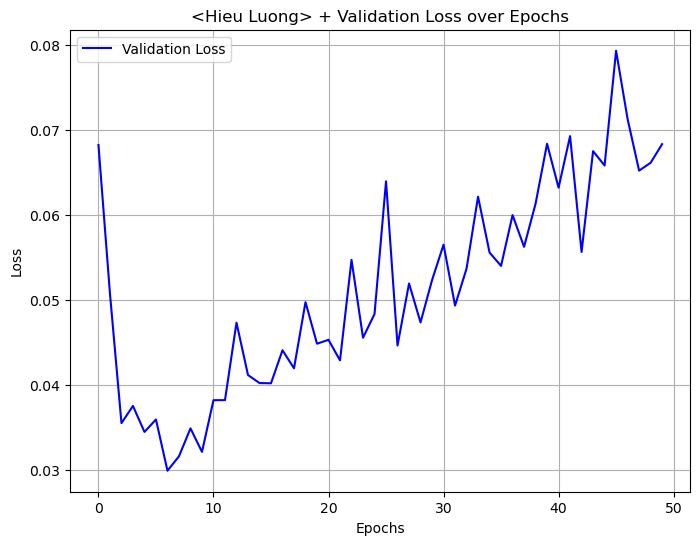

In [17]:
def plot_valid_loss(val_loss_history):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(val_loss_history)), val_loss_history, label="Validation Loss", color = "blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("<Hieu Luong> + Validation Loss over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
plot_valid_loss(val_loss_history)

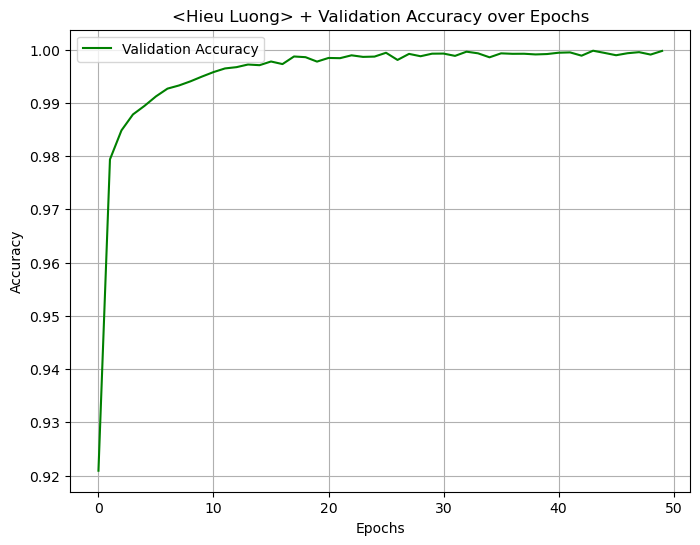

In [18]:
def plot_accuracy(accuracy_list):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(accuracy_list)), accuracy_list, label="Validation Accuracy", color = "green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("<Hieu Luong> + Validation Accuracy over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
plot_accuracy(accuracy_list)

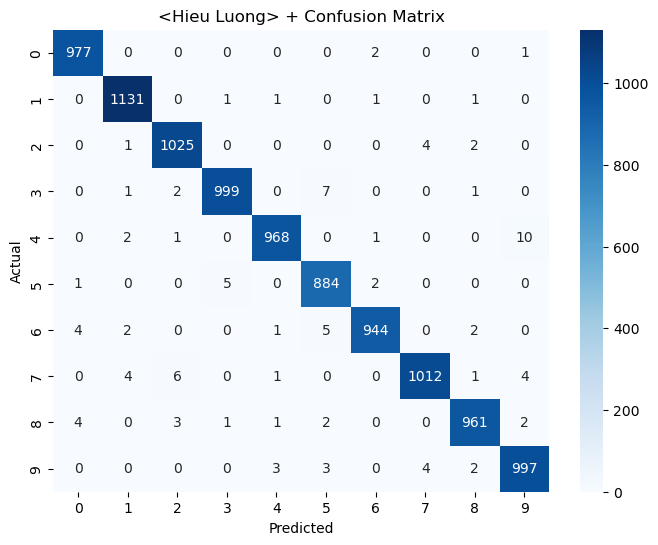

In [19]:
def plot_matrix(model,dataset, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X,y in DataLoader(dataset, batch_size = 64):
            X,y = X.to(device), y.to(device)
            predictions = torch.argmax(model(X), dim =1 )
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("<Hieu Luong> + Confusion Matrix")
    plt.show()
plot_matrix(model, test_dataset, device)

In [20]:
def visualize_predictions(model, dataset, device):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    
    for i, (X, y) in enumerate(DataLoader(dataset, batch_size=9, shuffle=True)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions = torch.argmax(y_pred, dim=1)

        for j in range(9):
            img = X[j].cpu().squeeze()
            axes[j//3, j%3].imshow(img, cmap="gray")
            axes[j//3, j%3].set_title(f"Pred: {predictions[j].item()} | Actual: {y[j].item()}")
            axes[j//3, j%3].axis("off")

        break  # Only visualize one batch

    plt.tight_layout()
    plt.show()

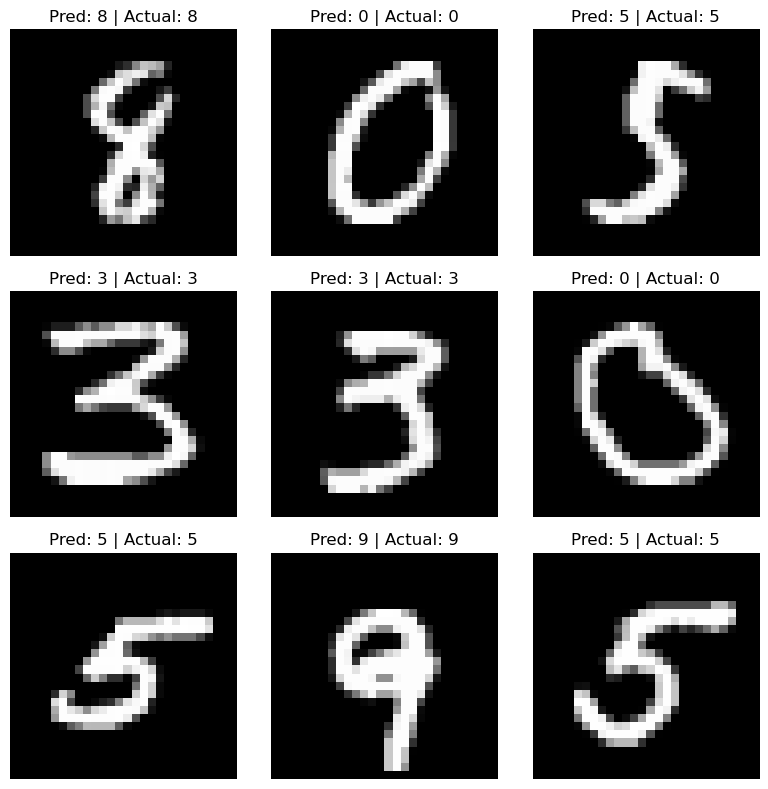

In [22]:
visualize_predictions(model, test_dataset, device)

In [25]:
# Please Save your model 1
PATH = "Lab.pt"
# PATHExample = "models/bit_train_CNN_acc85.pt" 
torch.save(model, PATH)

In [27]:
# load model
PATH = "Lab.pt"
model = CNN()
model.load_state_dict(torch.load(PATH).state_dict())
model.eval()

CNN(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=128, bias=True)
  )
)